In [1]:
%matplotlib inline

In [2]:
import numpy as np
import kali.carma
import kali
import gatspy
from matplotlib import pyplot as plt
from lsstlc import lsstlc # derived LSST lightcurve sub-class

/home/kali/python/kali/lc.py:29: UserWarning: No display environment! Using matplotlib backend "Agg"
  warnings.warn('No display environment! Using matplotlib backend "Agg"')
/home/conda/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


# Section 1
### Opsim minion_1016 & CARMA(2,1)

#### .npz file structure
Two named arrays are stored in .npz file:
1. "pos_gap": [ra, dec, min_gap]. **min_gap** is the minimum time seperation between two observations within one night
2. "obsHist": Pointing history for that paticular point on the sky, including ['expMJD', 'fiveSigmaDepth', 'fieldDec', 'fieldRA', 'filter', 'expDate', 'night'], where more columns can be added if required. In thie notebook, to get the observation time, I used **expDate**, which express the time in seconds since the beinging of the survey.

In [3]:
npz = np.load('/home/mount/obs_hist.npz') # load MAF output from file, which was saved from the obs_hist notebook
pos_gap = npz['pos_gap'] # [ra, dec, min_gap]
obsHist = npz['obsHist'] # obsHist in structured array
date = obsHist['expDate'] # get expDate from history

### 1.1  Available arguments for CARMATask
1. **nthreads: **number of hardware threads
2. **nburn: **Number of light curve steps to burn
3. **nwalker: **Number of MCMC walkers
4. **nsteps: **Number of MCMC steps 
5. **maxEvals: **Maximum number of evaluations when attempting to find starting location for MCMC
6. **xTol: **Fractional tolerance in optimized parameter value

In [4]:
# Initiate carma task
Task = kali.carma.CARMATask(2,1,nsteps = 1000)

# pick root values and amplitude (copyed from Kali's introduction notebook)

# "Let us set the first C-ARMA model in the Task object to have an autocorrelation \
# function that decays with two timescales - 107.8 d and 43.2 d. We shall set the MA timescale to be 5.5 d \
# and set the amplitude of the light curve (i.e. the square root of the asymptotic autocorrelation function) 
# to be 1.0" - direct quote from Kali's introduction notebook
r_1 = (-1.0/107.8) + 0j
r_2 = (-1.0/33.2) + 0j
m_1 = (-1.0/5.5) + 0j
amp = 1.0

Rho = np.array([r_1, r_2, m_1, amp]) # put the selected paramenters into array format
Theta = kali.carma.coeffs(2, 1, Rho) # use the array of roots above to solve for coefficients
print Theta # print out the calculated coefficients
print Task.check(Theta) # check whether computed coefficients make sense, if True then OK

[ 0.03939692  0.00027941  0.0046724   0.0256982 ]
True


In [5]:
# convert min_gap from hours to days
dt = pos_gap[2]/24

# set CARMA task paremeters: 
# dt: sampling rate (one data point every dt), where the min_gap is used
# Theta: coefficients for the CARMA model obtained above
Task.set(dt, Theta)

# generate mock lightcurve, duration 10 years, using dt, Theta and of course also p=2, q=1
LC = Task.simulate(duration=3650)

# add simulated noise into lc, based on the c++ code of Kali, the noise is generated using a gaussian
# random number generator, with mean=0, variance=flux*fracNoiseToSignal, where fracNoiseToSignal defaults to 0.001
Task.observe(LC)

### 1.2 A little expansion on how light curve is plotted
LC.t is the observed time in days  
LC.x is the purtuabation around the mean flux  
LC.y is the absolute (mean flux + x) flux plus a random gaussian noise drawn based on given fracNoiseToSignal (a property of LC) 

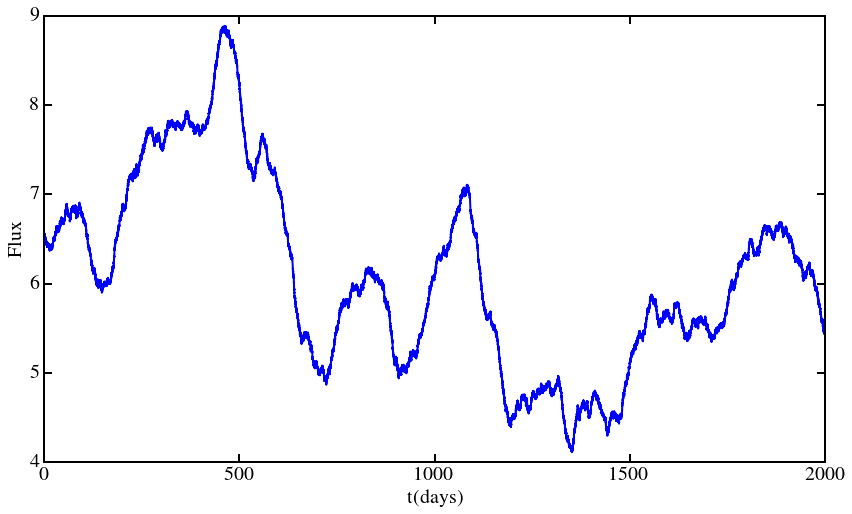

In [6]:
# now plot the mock lc
f = plt.figure(figsize=(14,8))
plt.ylabel('Flux')
plt.xlabel('t(days)')
plt.xlim(0,2000)

# np.mean(LC.y) - np.mean(LC.x) gives the mean flux
plt.plot(LC.t, LC.x - np.mean(LC.x) + np.mean(LC.y))

In [7]:
# down sample the mock lc based on pointing history, plese check out ./lsstlc.py for details
# In short, lsstlc select the data points that matched the observation history and put them into a new lc object.
dLC = lsstlc(pos_gap[0], pos_gap[1], obsHist['expDate'], LC, pos_gap[2])

### 1.3 Light Curve with down-sampled data overplotted

(0, 2000)

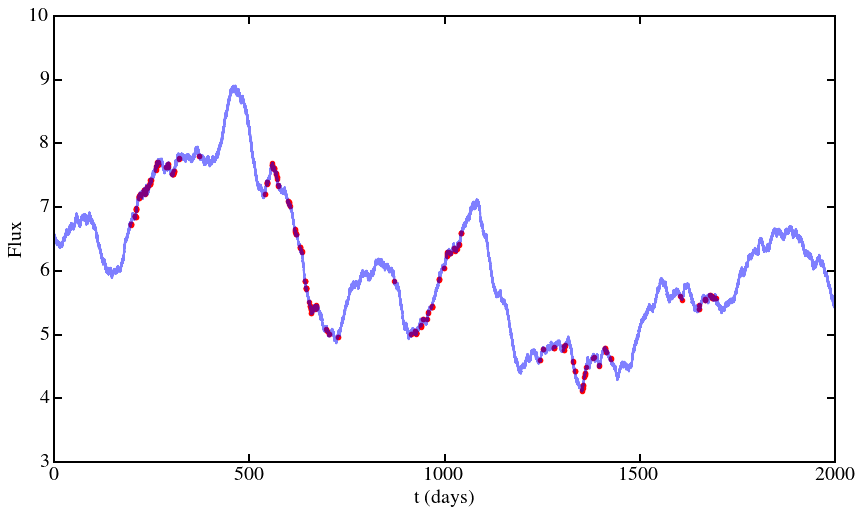

In [8]:
# now plot down sampled data on top of orginal mock lc
pts = dLC.plot_x_y_err() # get arguments for plot
f = plt.figure(figsize=(14,8))
plt.ylabel('Flux')
plt.xlabel('t (days)')
plt.scatter(pts[2], pts[3], color='r')
plt.plot(dLC.mockLC.t, dLC.mockLC.y, alpha=0.5)
plt.xlim(0,2000)

# Section 2 
### 2.1 Periodogram

I looked at different ways to impletment LombScargle periodogram.  

One is **gatspy** used by Kali and the other one is **astropy**. The good part of **gatspy** is that we can compute multiband periodogram, the method is described [here](http://adsabs.harvard.edu/abs/2015ApJ...812...18V). But **gatspy** is slower than **astropy** considering the small seperation between observations the large span of LSST.  

If we need the multiband periodogram, then we will have to use **gatspy**, since **astropy** doesn't support that. On the other hand, if we just want to look at light curves at individual bands, then **astropy** is the first choice.

/home/conda/lib/python2.7/site-packages/matplotlib/scale.py:93: RuntimeWarning: invalid value encountered in less_equal
  mask = a <= 0.0


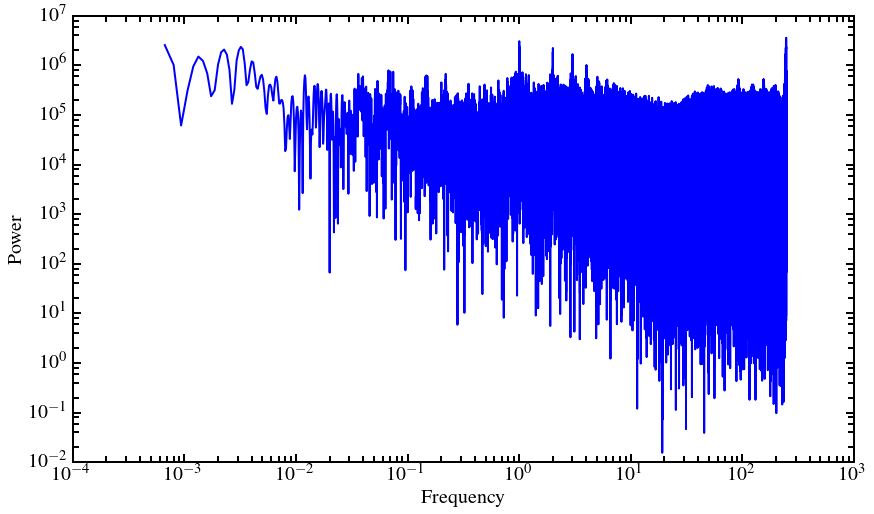

In [10]:
# plot periodogram using astropy
f, psd_sb, err = dLC.periodogram_sb()
#ratio = psdM[0]/psd_sb[0]
fig = plt.figure(figsize=(14,8))
plt.ylabel('Power')
plt.xlabel('Frequency')
plt.loglog(f, psd_sb)
#plt.loglog(freqsM, psdM/ratio)

### 2.2 Multiband Periodogram

In [17]:
from gatspy import periodic
from astropy.stats import LombScargle as ls

In [19]:
# declare lombscargle model to use
m = periodic.LombScargleMultibandFast()

In [20]:
# get frequencies for calculating periodogram using astropy
feqs = ls(dLC.t, dLC.y, dLC.yerr).autofrequency(maximum_frequency=1/dLC.mindt)

# convert to periods from frequency, gatspy requires periods
p = 1/feqs
p[:]=p[::-1]

# get filter from MAF
filts = obsHist['filter']

In [21]:
# configure LombScargle model
# set range to find best periods (don't know why)
m.optimizer.period_range = (2*dLC.meandt, dLC.T) 
# fit model with data
m.fit(dLC.t, dLC.y, dLC.yerr, filts)

In [22]:
# compute psd using the multiband algorithm
psd = m.periodogram(p)

/home/conda/lib/python2.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


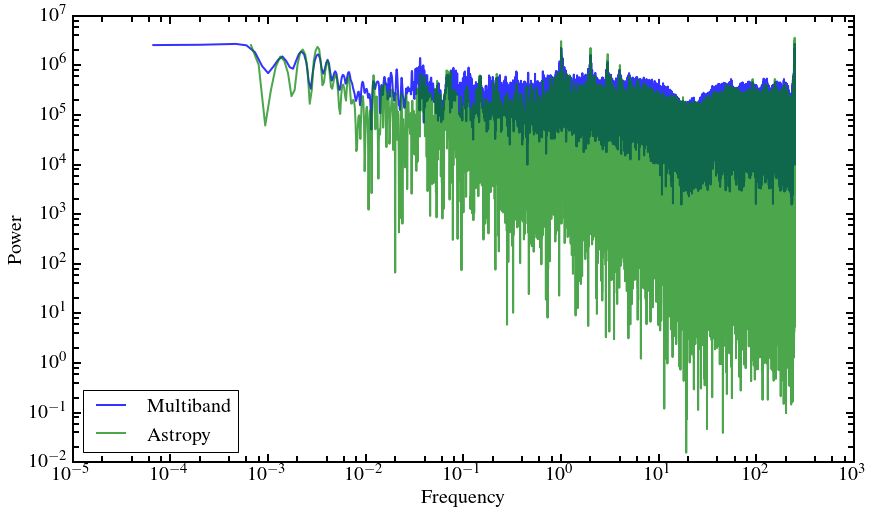

In [24]:
# plot the periodogram from the multiband LombScargle
normalRatio = psd_sb[0]/psd[0] # normalization ratio
fig = plt.figure(figsize=(14,8))
plt.ylabel('Power')
plt.xlabel('Frequency')
plt.loglog(feqs, psd*normalRatio, label='Multiband', alpha=0.8)
plt.loglog(f, psd_sb, label='Astropy', alpha=0.7)
plt.legend(loc=3)

### 2.3 Fit down-sampled light curve with CARMA(2,1)

In [11]:
# Find the best fit coefficients and print result
Task.fit(dLC)

0

In [12]:
# reconfigure the model with the best-fit parameters
Task.set(dt, Task.bestTheta)

0

### 2.4 Plot periodogram of the light curve with the psd of the model

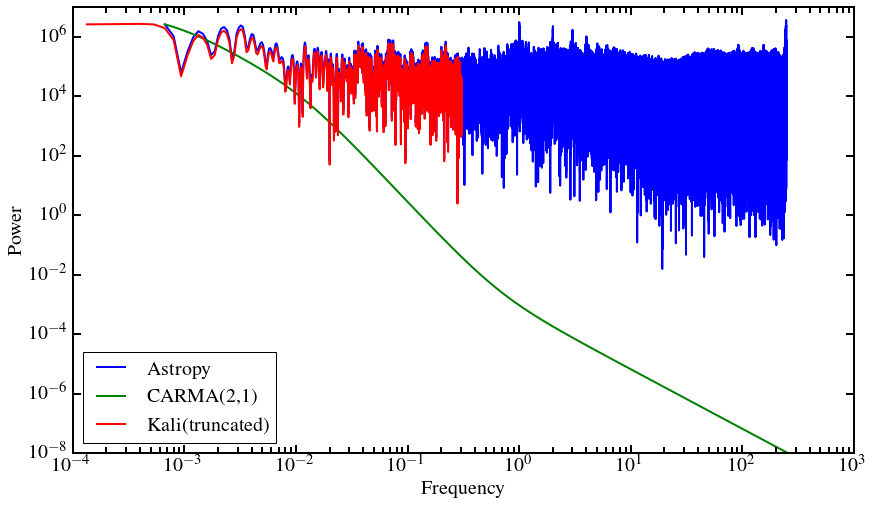

In [16]:
# plotting the psd obtained using Astropy, the psd from Kali (but truncated) and the psd of the model.

# get freqencies and psd for the CARMA model
freqsM, psdM, psdNumer, psdDenom, psdNumerComp, psdDenomComp = Task.psd(start=1/dLC.T, stop = 1/dLC.mindt)

# get psd from Astropy LombScargle
feqsK, psdK, errK = dLC.periodogram()

# normalize
ratio = psdM[0]/psd_sb[0]
ratioK = psdK[0]/psd_sb[0]

fig = plt.figure(figsize=(14,8))
plt.ylabel('Power')
plt.xlabel('Frequency')
plt.loglog(f, psd_sb, label='Astropy')
plt.loglog(freqsM, psdM/ratio, label='CARMA(2,1)')
plt.loglog(feqsK, psdK/ratioK, label='Kali(truncated)')
plt.legend(loc=3)

In [18]:
# Compare the best-fit parameter with input parameters
print ('Best fit roots: \n'+ '{}'.format(Task.bestRho))
print ('Input roots: {}'.format(Rho))
print ('Best fit coefficients: \n'+ '{}'.format(Task.bestTheta))
print ('Input coefficients: {}'.format(Theta))

Best fit roots: 
[-0.06953443+0.j -0.00413173+0.j -0.24545076+0.j  1.06723205+0.j]
Input roots: [-0.00927644+0.j -0.03012048+0.j -0.18181818+0.j  1.00000000+0.j]
Best fit coefficients: 
[ 0.07366615  0.0002873   0.00692693  0.02822125]
Input coefficients: [ 0.03939692  0.00027941  0.0046724   0.0256982 ]
